# Q1) CloverLeaf Bridge

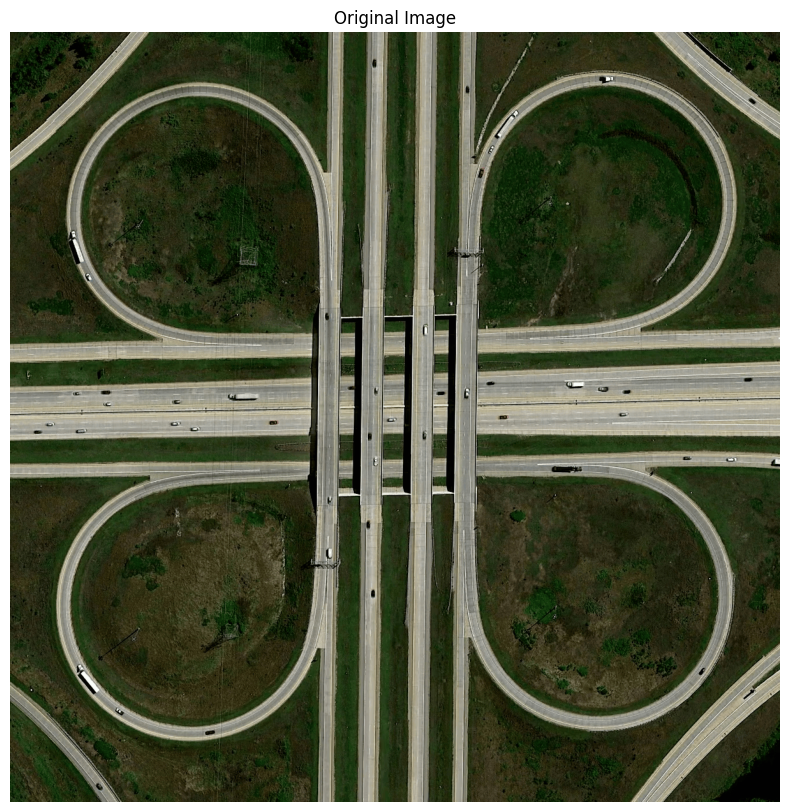

Image Dimensions: (1207, 1207, 3)
Pixel Value Range: 0 to 253


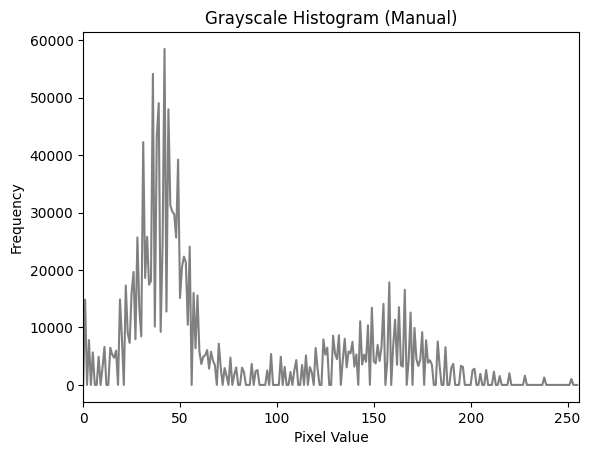

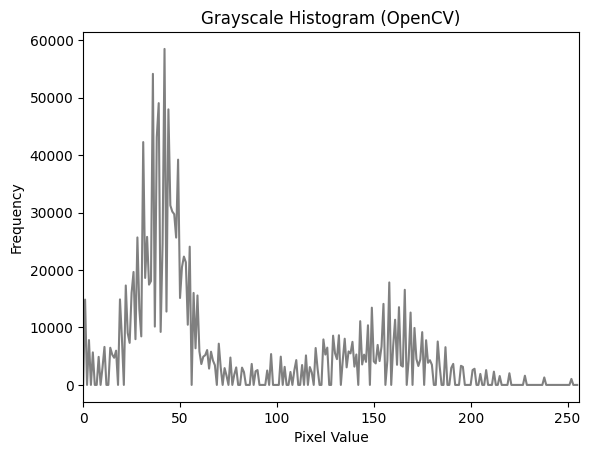

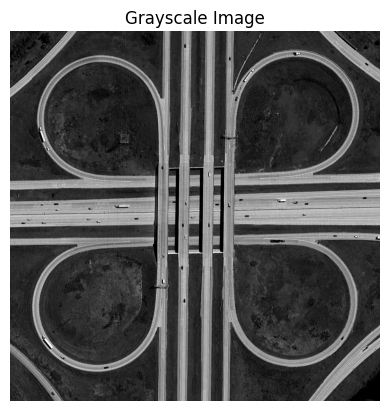

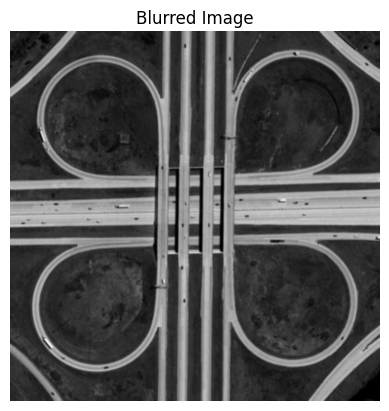

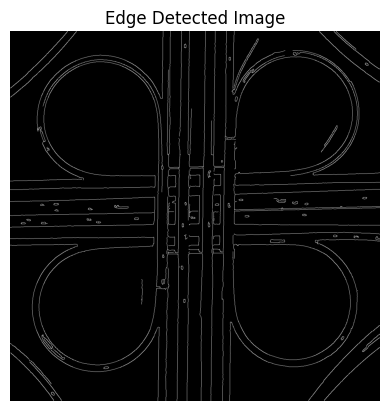

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '/kaggle/input/cv-a1d/cloverleaf_interchange.png'

def load_cloverleaf_image(filepath):
    # To Load the image in color mode
    image = cv2.imread(filepath, cv2.IMREAD_COLOR)
    return image

def display_image_info(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    print(f"Image Dimensions: {image.shape}")
    print(f"Pixel Value Range: {image.min()} to {image.max()}")

def compute_histogram(image, bins=256):
    # Converting image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Computing histogram using numpy(manual one)
    hist = np.zeros(bins)
    for value in gray_image.ravel():
        hist[value] += 1
    
    # Displaying histogram(manual)
    plt.figure()
    plt.title("Grayscale Histogram (Manual)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.plot(hist, color='gray')
    plt.xlim([0, bins])
    plt.show()
    
    # Comparing with OpenCV histogram function
    hist_cv = cv2.calcHist([gray_image], [0], None, [bins], [0, bins])
    plt.figure()
    plt.title("Grayscale Histogram (OpenCV)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.plot(hist_cv, color='gray')
    plt.xlim([0, bins])
    plt.show()

def preprocess_image(image):
    # Converting image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure()
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()
    
    # Applying Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)## gaussian kernel and stddev
    plt.figure()
    plt.imshow(blurred_image, cmap='gray')
    plt.title("Blurred Image")
    plt.axis('off')
    plt.show()
    
    # Doing Edge detection using Canny
    edges = cv2.Canny(blurred_image, 50, 150) #(lower and upper gradient thresholds)
    plt.figure()
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detected Image")
    plt.axis('off')
    plt.show()
    return edges


if __name__ == "__main__":
    image = load_cloverleaf_image(image_path)
    display_image_info(image)
    compute_histogram(image)
    preprocessed_image = preprocess_image(image)


## Inference
Both the manual and OpenCV histograms produce identical results, confirming their accuracy. OpenCV's cv2.calcHist() is significantly faster due to internal optimizations, making it ideal for performance-critical tasks.
Manual implementation provides flexibility for customizations, such as non-standard bin sizes or normalization techniques.
For general use cases, OpenCV's implementation is preferred for its speed and simplicity, while the manual method is useful for experimental purposes.

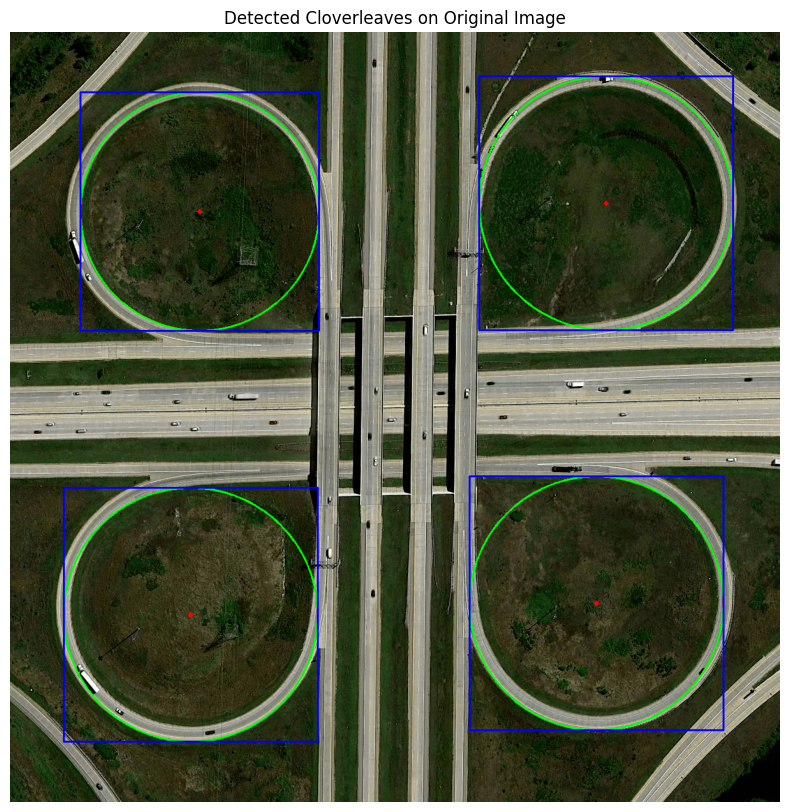

Detected Radii: [187, 199, 199, 199]
Approximate Areas by Radius (in square pixels): [109858.35350338147, 124410.2106748094, 124410.2106748094, 124410.2106748094]
Approximate Areas by Pixel Count (in square pixels): [109845, 124381, 124381, 124381]


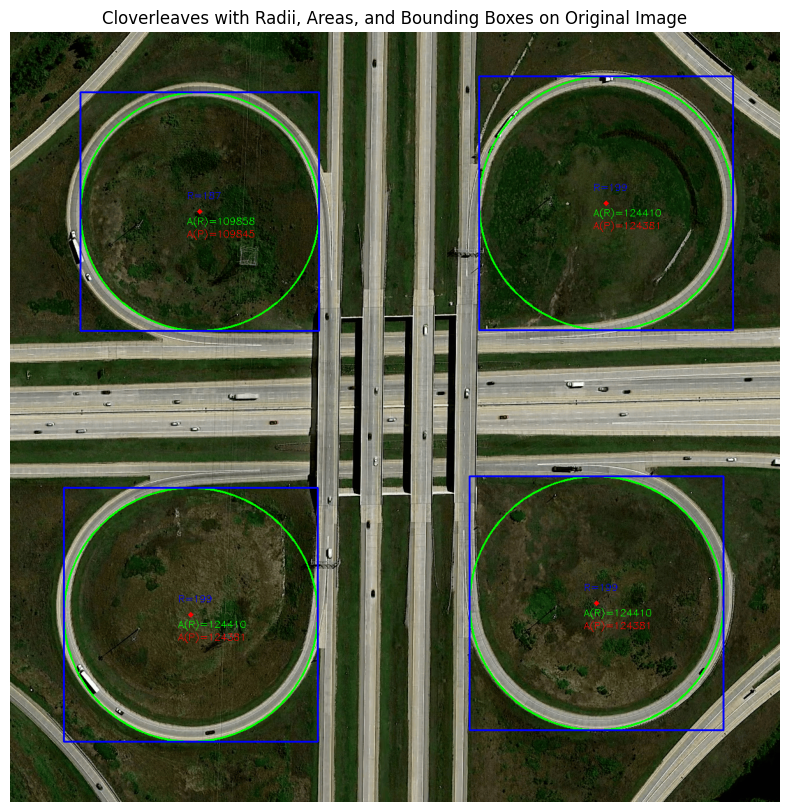

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_cloverleaves(preprocessed_image, original_image):
    # Using Hough Circle Transform to detect circles
    circles = cv2.HoughCircles(
        preprocessed_image, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, #inverse ratio of accumulator resolution to image resolution(Low-> High precision)
        minDist=50, #between detected circles
        param1=5, #high thresold for inbuilt canny
        param2=50, #threshold for accumulator(low->high FP)
        minRadius=160, #for filtering circles
        maxRadius=200
    )
    
    output_image = original_image.copy()
    
    # Drawing the detected circles and bounding boxes
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            #outer circle
            cv2.circle(output_image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            #center of the circle
            cv2.circle(output_image, (i[0], i[1]), 2, (0, 0, 255), 3)
            #bounding box
            top_left = (i[0] - i[2], i[1] - i[2])
            bottom_right = (i[0] + i[2], i[1] + i[2])
            cv2.rectangle(output_image, top_left, bottom_right, (255, 0, 0), 2)
    
    return circles, output_image


def calculate_radii(circles):
    if circles is not None:
        radii = [circle[2] for circle in circles[0, :]]
        return radii
    return []

def calculate_area_by_radius(radii):
    areas = [np.pi * (r ** 2) for r in radii]
    return areas


def calculate_area_by_pixel_count(image, circles):
    if circles is None:
        return []

    areas = []
    for circle in circles[0, :]:
        mask = np.zeros_like(image, dtype=np.uint8)
        center = (circle[0], circle[1])
        radius = circle[2]

        # Creating a circular mask for the detected cloverleaf
        cv2.circle(mask, center, radius, 255, -1)

        # Counting non-zero pixels (white pixels) in the mask
        area = cv2.countNonZero(mask)
        areas.append(area)

    return areas

if __name__ == "__main__":
    circles, marked_image = detect_cloverleaves(preprocessed_image, image)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Cloverleaves on Original Image")
    plt.axis('off')
    plt.show()

    radii = calculate_radii(circles)
    print(f"Detected Radii: {radii}")

    # Method 1: Calculating area using radius
    areas_by_radius = calculate_area_by_radius(radii)
    print(f"Approximate Areas by Radius (in square pixels): {areas_by_radius}")

    # Method 2: Calculating area using pixel counting
    areas_by_pixel_count = calculate_area_by_pixel_count(preprocessed_image, circles)
    print(f"Approximate Areas by Pixel Count (in square pixels): {areas_by_pixel_count}")

    # Visualizing the radii and areas on the original image
    if circles is not None:
        for i, circle in enumerate(circles[0, :]):
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.putText(
                marked_image, 
                f'R={radius}', 
                (center[0] - 20, center[1] - 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (255, 0, 0), 
                1
            )
            cv2.putText(
                marked_image, 
                f'A(R)={int(areas_by_radius[i])}', 
                (center[0] - 20, center[1] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (0, 255, 0), 
                1
            )
            cv2.putText(
                marked_image, 
                f'A(P)={int(areas_by_pixel_count[i])}', 
                (center[0] - 20, center[1] + 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (0, 0, 255), 
                1
            )
    
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
        plt.title("Cloverleaves with Radii, Areas, and Bounding Boxes on Original Image")
        plt.axis('off')
        plt.show()


## Inference:-
Conversion to Grayscale was done to simplify the image by removing color information, as the task focuses on structural patterns (cloverleaf shapes) rather than colors. This reduces computational complexity while retaining essential structural details.
Gaussian Blur was done to reduce noise and smoothen the image, making edge detection more robust.
Size of the Gaussian kernel was chosen large enough to suppress minor noise. while Standard deviation, provides a balanced blur to retain significant features while removing noise.

Edge Detection using Canny highlights strong edges to emphasize circular boundaries of cloverleaves.
The Thresholds for edge detection were chosen to balance edge detection sensitivity and noise reduction.

Circle Detection using Hough Circles detects circular features representing cloverleaf sections.


## Reasoning:
### Preprocessing Techniques:

* Grayscale conversion simplifies the image to a single channel, focusing on intensity values rather than color, making further operations computationally efficient.
* Gaussian blur reduces noise and smoothens the image, crucial for accurate edge detection, as noise can create false edges.
* Canny edge detection highlights strong and relevant edges, helping identify circular structures. Parameters like thresholds and aperture size were tuned for optimal detection.


### Detection Method and Radius Calculation:
Hough Circle Transform was used for circle detection, which calculates the radius of detected circles based on edge alignments in parameter space. The method assumes cloverleafs to be approximately circular, making radius-based area calculation straightforward. Detected radii ([187, 199, 199, 199]) align well with visual expectations.

### Comparison of Area Estimation Methods:

* Radius-based Area: Assumes a perfect circle, using the formula for area of circle.This is computationally efficient but sensitive to errors in radius estimation.
* Pixel Count: Directly counts white pixels within a circular mask, which accounts for irregularities but is slower and depends on accurate edge delineation. The results from both methods are closely aligned, with minor differences due to the assumptions in radius-based estimation and edge irregularities in pixel counting.


### Assumptions and Errors:

* Circular Assumption: Cloverleafs are treated as perfect circles, which may not be entirely accurate.
* Edge Accuracy: Noise or incomplete edges can affect the accuracy of both detection and area calculations.
* Pixel Count Dependency: Relies on accurate masking and thresholding, which could misrepresent areas in highly textured regions.


-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------


# Q2(Line Segmentation in Historical Document)

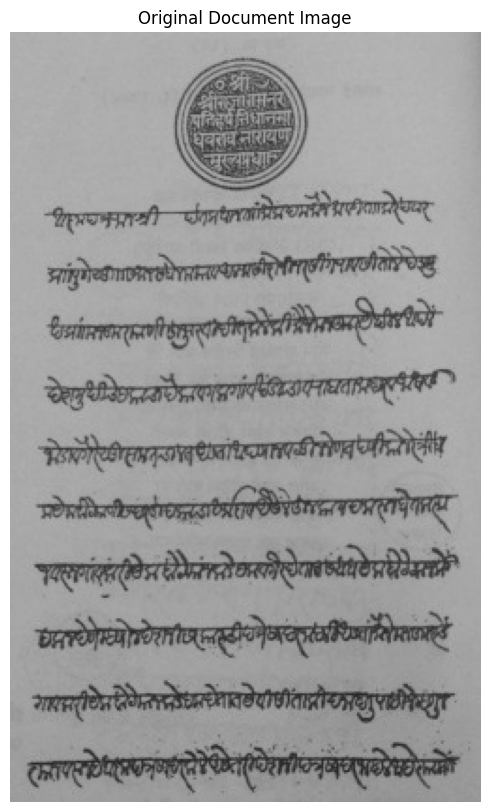

Image Dimensions: (411, 251, 3)
Pixel Value Range: Min = 28, Max = 190


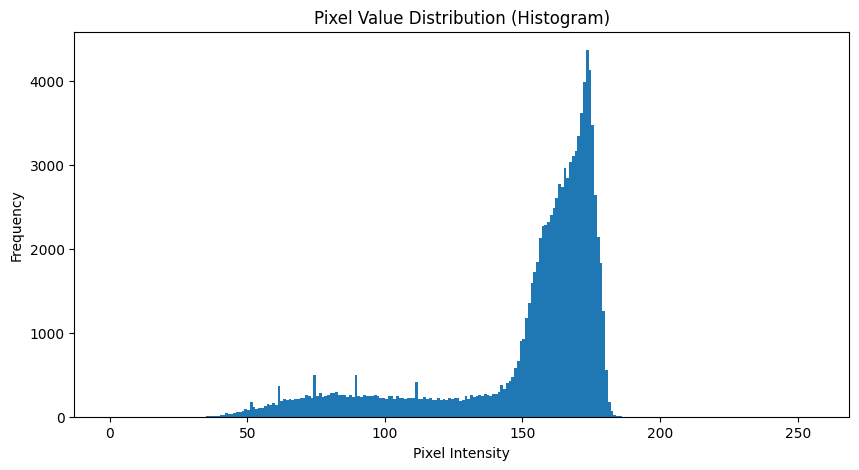

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_document_image(file_path):
    image = cv2.imread(file_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Document Image")
    plt.axis('off')
    plt.show()

    print(f"Image Dimensions: {image.shape}")
    print(f"Pixel Value Range: Min = {image.min()}, Max = {image.max()}")

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 5))
    plt.hist(gray_image.ravel(), bins=256, range=(0, 256))
    plt.title("Pixel Value Distribution (Histogram)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()
    return image

file_path = '/kaggle/input/cv-a1d/historical-doc.png'
image = load_document_image(file_path)


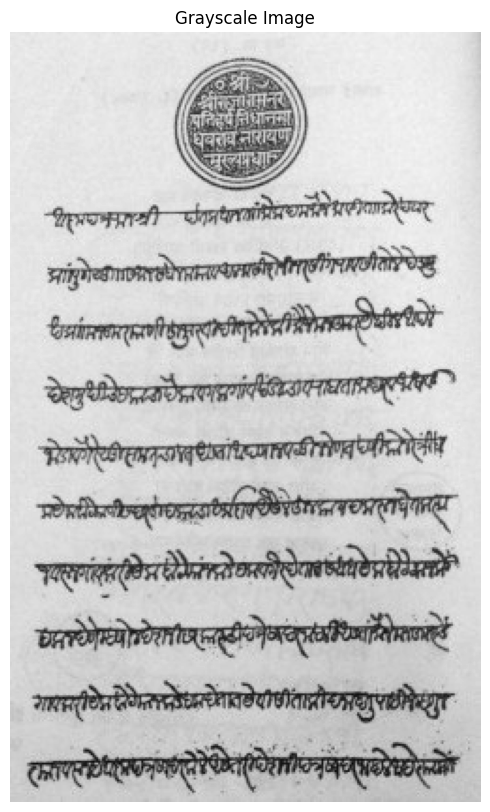

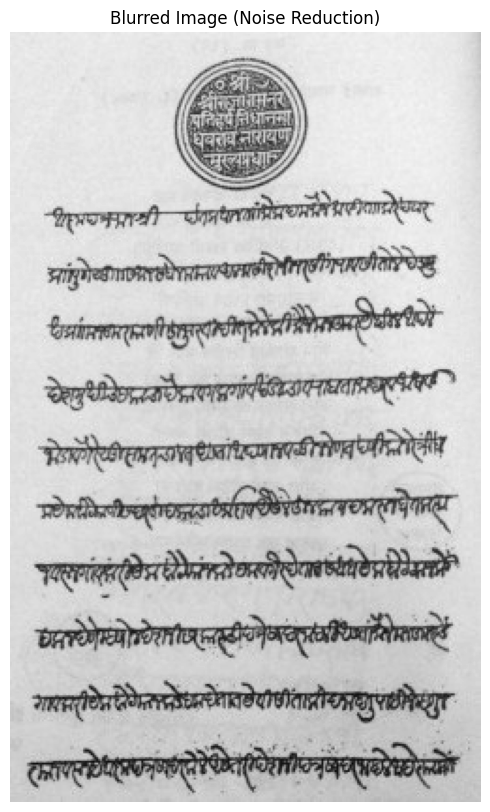

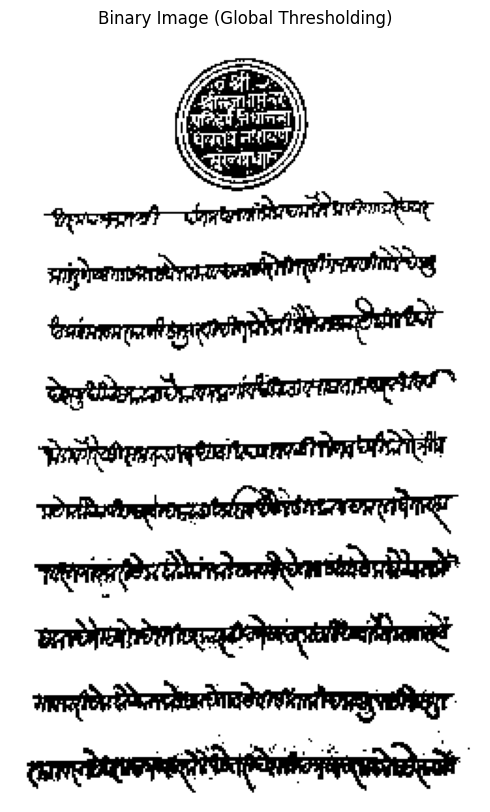

In [2]:
def preprocess_image(image):
    # Converting to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 10))
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

    # Noise reduction using Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray_image, (1,1),0)
    plt.figure(figsize=(10, 10))
    plt.imshow(blurred_image, cmap='gray')
    plt.title("Blurred Image (Noise Reduction)")
    plt.axis('off')
    plt.show()

    # Binarization using global thresholding
    _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binary Image (Global Thresholding)")
    plt.axis('off')
    plt.show()

    return binary_image

preprocessed_image = preprocess_image(image)


### Inference:

* Grayscale Conversion: The conversion to grayscale simplifies the image by reducing it to a single channel, making it computationally efficient and focusing only on intensity variations, which are critical for text line detection.
* Gaussian Blur: Gaussian Blur with a small kernel size (1,1) minimizes noise without overly smoothing the image, retaining the sharpness of text boundaries while eliminating minor variations that could disrupt thresholding.
* Binarization (Global Thresholding + Otsu’s): This step separates text from the background by assigning pixel values to binary levels (black and white). Otsu’s method dynamically determines the optimal threshold, making it robust to varying illumination, and prepares the image for contour-based line detection.



607


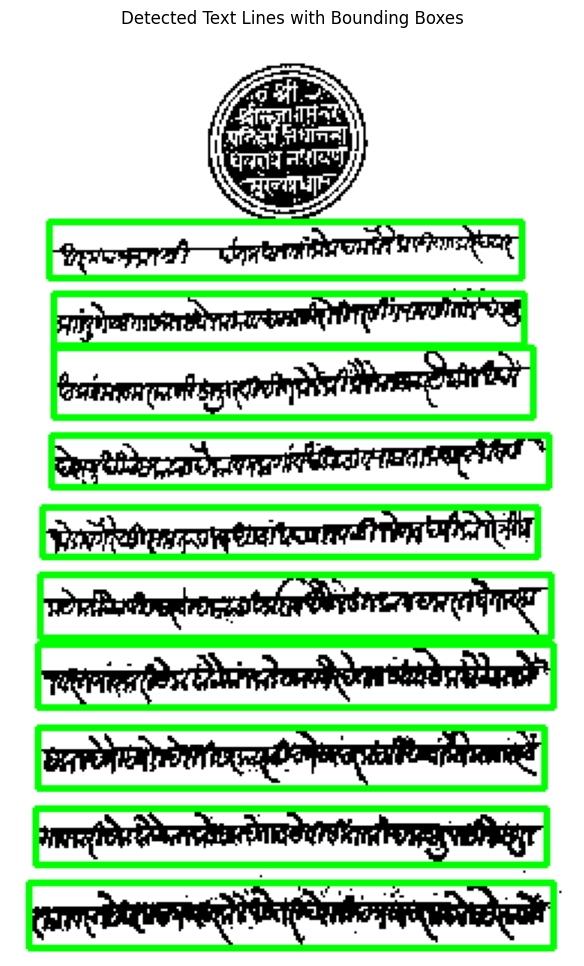

Saved 10 cropped text lines to 'lines_output'


In [29]:
import os

def detect_lines_with_bboxes(image, output_dir="lines_output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
    print(len(contours))

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    line_num = 1

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filtering out small noise by area or height
        if h > 5 and h< 40 and w > 80:
            # Drawing rectangle around the text line
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Crop and save each line
            cropped_line = image[y:y + h, x:x + w]
            line_path = os.path.join(output_dir, f"line_{line_num}.png")
            cv2.imwrite(line_path, cropped_line)
            line_num += 1

    # Displaying the image with bounding boxes
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Text Lines with Bounding Boxes")
    plt.axis('off')
    plt.show()

    print(f"Saved {line_num - 1} cropped text lines to '{output_dir}'")
    return output_image

bboxes_image = detect_lines_with_bboxes(preprocessed_image)


### Inference:

* Performance: The algorithm effectively detects text lines by leveraging contour detection and bounding box filtering, ensuring small noises are ignored and focusing on text-like regions.
* Strengths: The height (h) and width (w) filters improve accuracy by excluding artifacts and irrelevant contours, while sorting contours ensures proper ordering of lines.
* Limitations: The algorithm may fail in cases of overlapping text lines or curved text (e.g., in the circular seal), as it assumes rectangular regions. Additionally, very faint or broken text can be missed due to insufficient contrast in the preprocessed image.
* Suboptimal Results: The use of cv2.RETR_LIST might detect unnecessary contours like large background regions, and improper filtering thresholds (h > 5 and h < 40) can fail to generalize across varied text sizes.


Further improvements, such as adaptive filtering or incorporating morphological operations, can address these limitations.

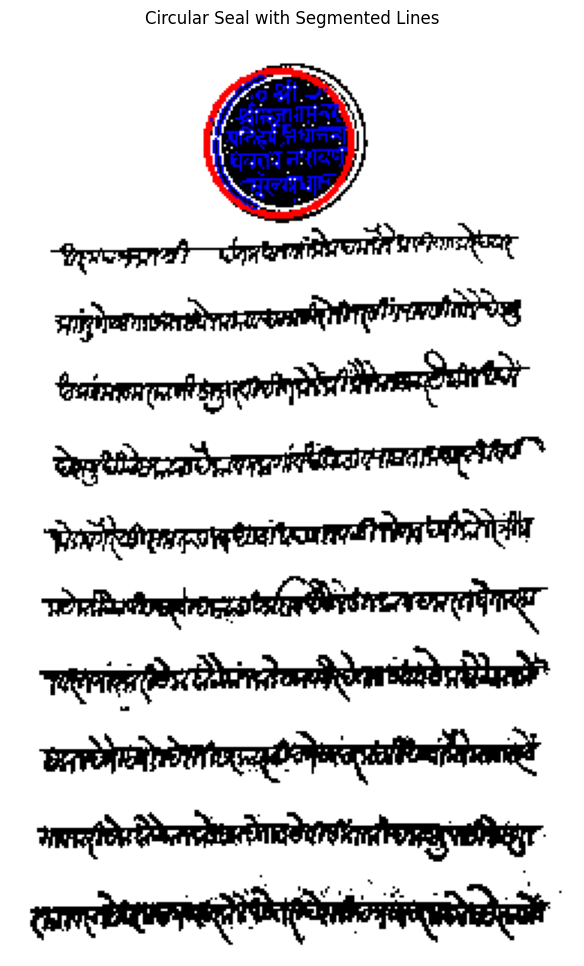

Saved 62 cropped text lines from circular seal to 'circle_lines_output'


In [30]:
def segment_lines_in_seal(image, output_dir="circle_lines_output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Detecting the circular region
    circles = cv2.HoughCircles(
        image, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=200, 
        param1=120, 
        param2=30, 
        minRadius=30, 
        maxRadius=50
    )

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    line_num = 1

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            # Drawing the circular seal
            cv2.circle(output_image, center, radius, (0, 0, 255), 2)

            # Masking the circular region and find contours within it
            mask = np.zeros_like(image, dtype=np.uint8)
            cv2.circle(mask, center, radius, 255, -1)
            masked_image = cv2.bitwise_and(image, image, mask=mask)

            # Finding and save text lines within the circle
            contours, _ = cv2.findContours(masked_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
            # print(contours)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                if h < 50 and h>1 and w < 50:
                    cropped_line = masked_image[y:y + h, x:x + w]
                    line_path = os.path.join(output_dir, f"circle_line_{line_num}.png")
                    epsilon = 0.00001 * cv2.arcLength(contour, True)
                    polygon = cv2.approxPolyDP(contour, epsilon, True)
        
                    # Drawing polygonal boundary
                    cv2.polylines(output_image, [polygon], isClosed=True, color=(255, 0, 0), thickness=1)
                    cv2.imwrite(line_path, cropped_line)
                    line_num += 1

    # Displaying the image with circular region overlaid
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Circular Seal with Segmented Lines")
    plt.axis('off')
    plt.show()

    print(f"Saved {line_num - 1} cropped text lines from circular seal to '{output_dir}'")
    return output_image

seal_segmented_image = segment_lines_in_seal(preprocessed_image)


### Inference:

* Challenges: Segmenting text lines within the circular seal is more complex than the main document because of curved text orientations and limited space, which standard rectangular bounding boxes cannot effectively handle.
* Seal-Specific Issues: The circular shape introduces overlapping contours, making it harder to distinguish individual text lines. Variations in text alignment within the seal exacerbate segmentation errors.
* Performance Limitations: The contour-based method relies heavily on clear separation between lines. Faint or broken text within the seal can be missed, and small text regions may be wrongly discarded due to filtering thresholds (h < 50 and w < 50).
* Improvement Potential: Using polygonal boundaries instead of rectangular ones helps better fit curved text. However, tuning HoughCircles parameters (e.g., param1, param2, minRadius, maxRadius) is critical for accurate circle detection.


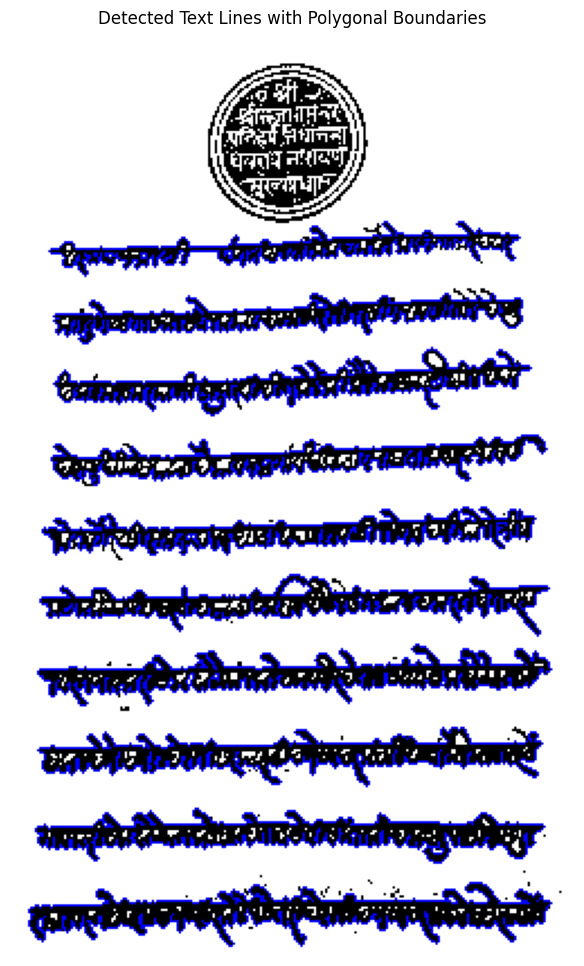

In [12]:
def detect_lines_with_polygons(image):
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
         x, y, w, h = cv2.boundingRect(contour)
         # Filtering out small noise by area or height
         if h > 5 and h< 40 and w > 80:
             # Approximating a polygon for each contour
             epsilon = 0.00001 * cv2.arcLength(contour, True)
             polygon = cv2.approxPolyDP(contour, epsilon, True)

            # Drawing polygonal boundary
             cv2.polylines(output_image, [polygon], isClosed=True, color=(255, 0, 0), thickness=1)

    # Displaying the image with polygonal boundaries
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Text Lines with Polygonal Boundaries")
    plt.axis('off')
    plt.show()

    return output_image

polygon_image = detect_lines_with_polygons(preprocessed_image)


### Inference:
1.	Advantages of Using Polygons:

* Precision: Polygonal boundaries adapt more closely to the irregular shapes and orientations of text lines, particularly in cases of slanted or curved text.
* Noise Reduction: Smaller and irrelevant contours are excluded more effectively as polygons conform better to the actual text boundaries.
* Seal Text Segmentation: Polygons are especially beneficial in handling circular or non-linear text regions, such as those within seals, compared to rectangular boxes.

2.	Disadvantages:
	
* Computational Overhead: Generating polygonal approximations involves additional computations (cv2.approxPolyDP) compared to straightforward bounding boxes.
* Parameter Sensitivity: The accuracy of polygon boundaries is sensitive to parameters like epsilon in cv2.approxPolyDP. Too large or too small values can result in underfitting or overfitting the text boundary.
* Complexity in Post-Processing: Polygons require more sophisticated handling for cropping and saving compared to rectangles.

3.	Impact on Results:

* Improved Fit: For non-rectangular text lines or varying orientations, polygons provide tighter       and more meaningful segmentations.
* Error Margins: While polygons improve precision, their performance can degrade in noisy images where contours are fragmented, requiring robust preprocessing to ensure optimal results.


In [28]:
# import shutil
# import os

# def delete_kaggle_folder(folder_path):
#     if os.path.exists(folder_path):
#         shutil.rmtree(folder_path)
#         print(f"Deleted folder: {folder_path}")
#     else:
#         print(f"Folder not found: {folder_path}")

# folder_to_delete = "/kaggle/working/lines_output"
# delete_kaggle_folder(folder_to_delete)

Deleted folder: /kaggle/working/lines_output


In [32]:
import shutil

def download_kaggle_folder(folder_path, output_zip):
    shutil.make_archive(output_zip, 'zip', folder_path)
    print(f"Folder zipped as: {output_zip}.zip")

folder_to_zip = "/kaggle/working/lines_output"
output_zip_name = "/kaggle/working/lines_output"
download_kaggle_folder(folder_to_zip, output_zip_name)


Folder zipped as: /kaggle/working/lines_output.zip
